<a href="https://colab.research.google.com/github/salocinnobot/Fashion-MNIST/blob/main/Fashion-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization of notebook to work with Kaggle Dataset
# **SKIP if working with keras package**

In [8]:
!pip install kaggle

In [10]:
! cd ~/.kaggle

In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download -d zalando-research/fashionmnist

 92% 63.0M/68.8M [00:00<00:00, 173MB/s]
100% 68.8M/68.8M [00:00<00:00, 165MB/s]


In [14]:
! unzip fashionmnist

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [15]:
## We see here, that Google Colab provide a LINUX directory from which we can access our data
!ls

fashion-mnist_test.csv	 kaggle.json		 t10k-labels-idx1-ubyte
fashion-mnist_train.csv  sample_data		 train-images-idx3-ubyte
fashionmnist.zip	 t10k-images-idx3-ubyte  train-labels-idx1-ubyte


In [16]:
## Imports Colab Notebooks as a folder from Google Drive into Google Colab Directory. 
## Folder can be found under gdrive/MyDrive/Colab Notebooks/colab.ipynb
## Utilized by hyperas to run optimization (notebook_name = 'notebook')
## Please see https://github.com/maxpumperla/hyperas/issues/83 for more information


from google.colab import drive
drive.mount('/gdrive')
%ls /gdrive

Mounted at /gdrive
MyDrive/


# **A guide to this workbook**


- Section 1: Separating our training/test data, along with further splitting our training data into validation data

- Section 2: Encoding our y_values into one-hot-encoded vectors using to_categorical

- Section 3: Reviewing important terms necessary for understanding convolutional neural networks (convolutions, kernels, filters)

- Section 4: Applying convolutions (edge detection, blur, upsampling) to our training images

- Section 5: Applying our first CNN using hyperas




## **Section 1:**

Let's separate our training/test data

In [17]:
!pip install hyperopt
!pip install hyperas

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from skimage.measure import block_reduce
from scipy.signal import convolve2d
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [ ]:
from keras.datasets import fashion_mnist
## If using Keras Package
training_data = fashion_mnist

In [55]:
training_data = pd.read_csv("fashion-mnist_train.csv")
test_data = pd.read_csv("fashion-mnist_test.csv")

In [56]:
test_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [72]:
print(training_data.shape)
print(test_data.shape)

(60000, 785)
(10000, 785)


In [73]:
y = training_data['label']
X = training_data.drop('label', axis = 1)

In [74]:
(X_train, y_train) = X, y

In [76]:
X_train = X_train.to_numpy()/255.
X_train = X_train.reshape(-1, 28, 28)
y_train = y_train.to_numpy()

In [61]:
y = test_data['label']
X = test_data.drop('label', axis = 1)

In [62]:
(X_test, y_test) = X, y

In [63]:
X_test = X_test.to_numpy()/255.
X_test = X_test.reshape(-1, 28, 28)
y_test = y_test.to_numpy()

In [64]:
## Let's split our training data into a validation set
X_train, y_train, X_train_val, y_train_val = train_test_split(X_train, y_train, test_size = 0.2)

Let's visualize some of the images that we will be using for our Neural Network, to gain an intuition into the methods we could use.

In [29]:
def plot_images_in_a_row(ims, color):    
  'Takes a list/array of images and plots them spaced horizontally.'
  _, axs = plt.subplots(1, len(ims), figsize = (20,5))
  for im, ax in zip(ims, axs.ravel()):
    ax.imshow(im, cmap = color)
    ax.axis('off')

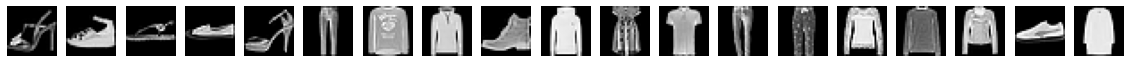

In [30]:
plot_images_in_a_row(X_train[21:40], "gray")

The images are of relatively small size (28, 28), thus the use of a convolutional neural net won't necessarily be maximizing the advantages of using kernels which is charactersitic of the CNN   

## **Section 2:** 

Let's encode our y_train and y_test as a categorical vector of 0, 1 to facilitate the use of categorical variables training our CNN.

In [78]:
y_train.shape

(60000,)

In [79]:
y_train_cat = keras.utils.to_categorical(y_train)
y_train_val_cat = keras.utils.to_categorical(y_train_val)
y_test_cat = keras.utils.to_categorical(y_test)

In [81]:
print(y_train_cat)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [82]:
print(y_train[0], y_train_cat[0], np.argmax(y_train_cat[0]))

2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 2


## **Section 3:**

Convolutions Overview

Let's go over some of the most important convolutions, to understand as to how best approach our CNN

Let's review quickly some intuitive interpretations of the relevant definitions for our CNN
- Kernel: A nxm matrix that is slid over our image. The operation of the kernel with the image is a multiplication, in which each value in our new image is a sum of the element-wise multiplication of every pixel in our kernel with the underlying pixel that it is being applied to.
- Filter: A filter is a concatentation of kernels of the form nxmxd, where d is the kernel specified to channel (in the case of RGB, there d would 3)
  - In the case of applying a filter across 3 channels, the RGB values would be summed to produce one final output image
  - In the case of our image data, we don't have to worry about the use of filters as we're only dealing with channel (grayscale)

Notes for convolutions in our CNN
- Add padding to the original image to allow for the kernel to slide over the boundaries of our image.
- On pooling methods:
  - Max pooling: Take the maximum of the pixels in that channel. 
    - Useful for when we have images that need brightening, as it takes the brightest pixel in that kernel (highest pixel value) and assigns that value to the value in the output image
  - Min pooling: Takes the minimum of the pixels in that channel.
    - Useful for when we have images that need darkening, as it takes the darkest image in that kernel (lowest pixel value) and assigns that value to the value in the output image
  - Average pooling: Takes the average of the pixels in that kernel in that channel
    - Useful for smoothing the edges of a image, Takes the average of the pixels in that kernel (average of the pixel values) and assigns that value to the value in the output image 

The convolutions applied to our training image:
- Ridge4
- Ridge8
- Sharpening 
- Edge Detection
- Upsampling

## **Section 4:**

Let's apply some of those convolutions to gain a better intuition into the operations being performed in our CNN

In [ ]:
X_train[0].shape

(28, 28)

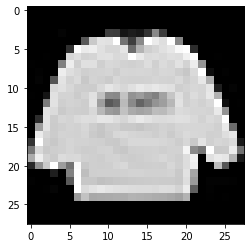

In [83]:
im = X_train[0]
plt.imshow(im, cmap = 'gray')

In [85]:
## Since our images only have one channel, we modify the convolve_each_channel(used to convolve multiple channels) into convolving the single channel
def convolve_single_channel(im, m):
  im_conv = im.copy()  
  im_conv[...] = convolve2d(im_conv[...], m, mode = 'same')
  return im_conv

## Since our images are of grayscale, we don't need to use convolve_and_merge as 
## only applies to mulit-channel images
def convolve_and_merge(im, m):
  return convolve_single_channel(im, m).sum(axis = -1)

In [86]:
## These were our original convolutions, used to find edges yet they don't work as well 
## as we'd like them to
m_ridge4 = np.array([[0.,-1,0],
                    [-1,4,-1],
                    [0,-1,0]]) 

m_ridge8 = np.array([[-1.,-1,-1],
                    [-1,8,-1],
                    [-1,-1,-1]]) 

m_sharpen = np.array([[0.,-1,0],
                    [-1,5,-1],
                    [0,-1,0]]) 

## Let's add some other convolutions to see how we can better extract the features necessary for our CNN
m_edge_1 = np.array([[-1, -2, -1],
                     [0,0,0],
                     [1,2,1]])

m_edge_2 = np.array([[ -1, 0, 1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])


## Here we change our blur size so we don't overpower the blur relative to our picture size
blur_size = 3
m_blur = np.ones((blur_size,blur_size))/blur_size**2

## Let's add a deconvolution (tranposed convolution) to see how the image will look with greater dimensions


Absolute difference between original image, and covolved image 385.1058823529412


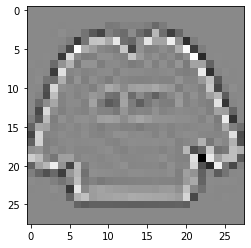

Absolute difference between original image, and covolved image 571.443137254902


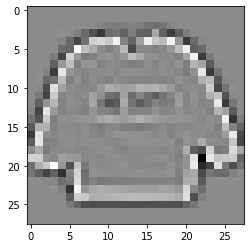

Absolute difference between original image, and covolved image 188.80784313725496


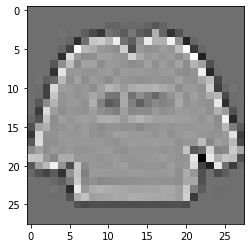

Absolute difference between original image, and covolved image 51.88583877995643


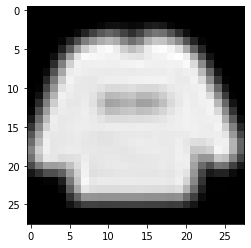

Absolute difference between original image, and covolved image 654.7372549019608


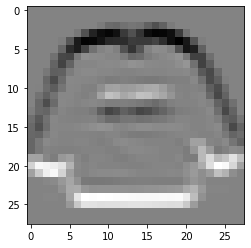

Absolute difference between original image, and covolved image 1111.372549019608


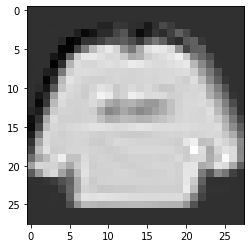

In [91]:
## Here we perform some convolutions for images that in our grayscale
images = np.array([])

for m in [m_ridge4, m_ridge8, m_sharpen, m_blur, m_edge_1, m_edge_2]:
  ims = convolve_single_channel(im, m)
  print(f'Absolute difference between original image, and convolved image: {np.sum(np.abs(ims - im))}')
  plt.imshow(ims, cmap = 'gray')
  plt.show()

In [92]:
## Let's perform an upsampling convolution using a sequential model (only way to upsample)
im_up = im.copy()
print(im_up.shape)
im_up = im_up.reshape(1, 28, 28, 1)
print(im_up.shape)

(28, 28)
(1, 28, 28, 1)


In [93]:
model = keras.models.Sequential()
model.add(keras.layers.UpSampling2D(input_shape = (28, 28, 1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 56, 56, 1)        0         
 )                                                               
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [94]:
y_hat_conv = model.predict(im_up)

In [95]:
y_hat_conv = y_hat_conv.reshape(56, 56)

Convolved Image: Absolute difference between original image, and covolved image: 1111.372549019608


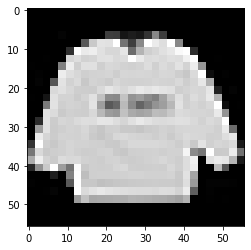

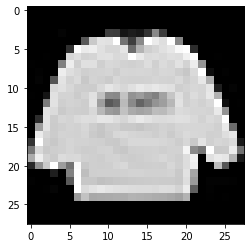

In [96]:
plt.imshow(y_hat_conv, cmap = 'gray')
print(f'Convolved Image: Absolute difference between original image, and covolved image: {np.sum(np.abs(ims - im))}')
plt.show()
plt.imshow(im, cmap = 'gray')
plt.show()

## **Section 5:**

Let's build a simple CNN using hyperas, a package used to optimize hyperparameters
- We reuse the architecture provided in MAS 4115 as a general architecture for which to experiment the optimizations of Hyperas.

Convolutions Overview

Let's go over some of the most important terms with respect to CNN's, to understand as to how best approach our architecture and neural net

- Dense Layer: A layer of neurons of size k. Keras allows us to stack Dense layers in a sequence

- Convolutional Layer: The convolutional layer is a layer of size k, where each neuron is a filter of kernels that are applied to the data using strides. These convolutional layers train kernels to extract "latent features" using backpropogation from the loss function corrections. These latent features are often abstract representations of information that allow the network to best classify the images. These convolutional layers are the basis of the CNN

Activations Overview

- Rectified Linear Unit (ReLU) Activation Function: The ReLU activation function is used to determine the activation of a single neuron, depending on the sign of the function output. The function returns a positive output, only if the output is greater than 0. This output is then used as the weight for that output's input into the next layer/function. The function returns 0, if the output is less than or equal to 0, which is used as the weight for that output's input into the next layer/function. The ReLU activation function is designed to intuitively model the activation of neurons firing in the brain.

- Sigmoid Function: The sigmoid function is used to determine the activation of a single neuron, depending on the output of the input with the sigmoid function. The key charateristic differentiating the sigmoid function from ReLU is the exponential nature of the sigmoid which characterizes the output a non-linear curve converging out of 0, and converging into 1. Another key characteristic of the sigmoid function is it's output parameterization between 0 and 1, which raises questions into the development of an architecture by instantiating very different types of function's with very different output

- Softmax Activation Function: A function used to determine the multinomial probabilities across the class of labels which we wish to predict. We use this function to determine the "score" that the image outputs to each class by leveraging the exponential function which allows that our probabilities sum up to 1. The label with the highest probability is chosen as the label for which we classify that image (talk about error from this probability)


On some of the optimizations of hyperparameters being performed  for our CNN

- The architecture provided to us, is of the form Conv2D-MaxPooling-Conv2D-MaxPooling-Conv2D-MaxPooling-Flatten-Dense
  - The parameters for which we seek to optimize in each of these layers is the following: 
    - Conv2D
      - Filters: We seek to optimize the number of filters, which are essentially the number of kernels we want to train. We vary this size between 8, 16, and 32
      - Kernel Size: We seek to optimize the kernel size's which are used to convolute our images in varying sizes/sections. We vary this size between (2,2), (3,3)
    - Max Pooling
      - Pool Size: We seek to optimize the number the pool size which are used to pool our pixel values in varying sizes/sections. We vary this size between (2,2), (3,3), (4,4)
    - Activation
      - Activation Types: We seek to optimize the type of activation that best categorizes the evaluation of our model. We vary the activation types between the ReLU and Sigmoid function.
    - Optimizer
      - Optimizer Types: We seek to optimize the type of optimization function that best finds the minima of the loss function which we seek to minimize. We vary the optimizer types between adam (classic stochastic gradient descent), rmsprop (a variation of gradient descent with momentum), sgd (a variation of gradient descent with momentum) 
      - Optimizer Learning Rates: We seek to optimize the learning rate of the optimization function that best models the rate of learning (descent) which minimzes our loss function 

In [103]:
def data3():
    from keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2)
    X_train = X_train.reshape(-1, 28, 28)
    X_train_val = X_train_val.reshape(-1, 28, 28)
    X_train = X_train.astype('float32')
    X_train_val = X_train_val.astype('float32')
    X_train /= 255.
    X_train_val /= 255.
    y_train = keras.utils.to_categorical(y_train)
    y_train_val = keras.utils.to_categorical(y_train_val)
    return X_train, y_train, X_train_val, y_train_val

In [155]:
def create_model(X_train, y_train, X_train_val, y_train_val): 
  ## Let's create a model instance called "model" of the Sequential 
  model = keras.models.Sequential()

  ## Let's consider adding an upsampling layer to increase the dimnesions of our original image (28,28 -> 56,56)
  #model.add(keras.layers.UpSampling2D(input_shape = (784, )))

  ## Let's specify the intial input size to our CNN
  model.add(keras.Input(shape = (28, 28, 1)))

  ## Here we initialize the FIRST Convolutional 2D layer, with varying sizes of filters
  model.add(keras.layers.Conv2D(filters = {{choice([8, 16, 32])}}, kernel_size ={{choice([(2,2), (3,3)])}}, use_bias = False, padding = 'same'))
 
  ## Let's intizalize an activation function for our Convolutional 2D layer, with varying sizes of activation types
  model.add(keras.layers.Activation({{choice(['relu', 'sigmoid'])}}))

  ## Let's initialize a pooling layer, with varying types of pools, and pool_sizes
  model.add(keras.layers.MaxPool2D(pool_size = {{choice([(2,2), (3,3), (4,4)])}}, padding = 'same'))

  ## Here we initialize the SECOND Convolutional 2D layer, with varying sizes of filters
  model.add(keras.layers.Conv2D(filters = {{choice([8, 16, 32])}}, kernel_size ={{choice([(2,2), (3,3)])}}, use_bias = False, padding = 'same'))

  ## Let's intizalize an activation function for our Convolutional 2D layer, with varying sizes of activation types
  model.add(keras.layers.Activation({{choice(['relu', 'sigmoid'])}}))

  ## Let's initialize a pooling layer, with varying types of pools, and pool_sizes
  model.add(keras.layers.MaxPool2D(pool_size = {{choice([(2,2), (3,3), (4,4)])}}, padding = 'same'))

  ## Here we initialize the SECOND Convolutional 2D layer, with varying sizes of filters
  model.add(keras.layers.Conv2D(filters = {{choice([8, 16, 32])}}, kernel_size ={{choice([(2,2), (3,3)])}}, use_bias = False, padding = 'same'))
 
  ## Let's intizalize an activation function for our Convolutional 2D layer, with varying sizes of activation types
  model.add(keras.layers.Activation({{choice(['relu', 'sigmoid'])}}))

  ## Let's initialize a pooling layer, with varying types of pools, and pool_sizes
  model.add(keras.layers.MaxPool2D(pool_size = {{choice([(2,2), (3,3), (4,4)])}}, padding = 'same'))

  adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
  rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
  sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})

  choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
  if choiceval == 'adam':
      optim = adam
  elif choiceval == 'rmsprop':
      optim = rmsprop
  else:
      optim = sgd

  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(10))
  model.add(keras.layers.Activation('softmax'))
      
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
  model.summary()

  model.fit(X_train, y_train,
              batch_size={{choice([128,256,512])}},
              epochs=5,
              verbose=2,
              validation_data=(X_train_val, y_train_val))
  score, acc = model.evaluate(X_train_val, y_train_val, verbose=0)
  print('Test accuracy:', acc)
  return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [156]:
notebook_name = os.path.join('..','gdrive','My Drive','Colab Notebooks','Fashion-MNIST')
print(notebook_name)

../gdrive/My Drive/Colab Notebooks/Fashion-MNIST


In [157]:
notebook_name = os.path.join('..','gdrive','My Drive','Colab Notebooks','Fashion-MNIST')


best_run, best_model, space = optim.minimize(model=create_model,
                                      data=data3,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      eval_space = True,
                                      return_space = True,
                                      trials=Trials(), notebook_name = notebook_name)

>>> Imports:
#coding=utf-8

try:
    from google.colab import drive
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import os
except:
    pass

try:
    from tensorflow import keras
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from skimage.measure import block_reduce
except:
    pass

try:
    from scipy.signal import convolve2d
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    from keras.datasets import fashion_mnist
except:
    pass

>>> Hyperas search space:

def get_space():
    return {
        'filters': hp.choice('filters', [8, 16, 32]),
 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



Epoch 1/5

375/375 - 20s - loss: 1.0993 - accuracy: 0.6092 - val_loss: 0.6161 - val_accuracy: 0.7790 - 20s/epoch - 52ms/step

Epoch 2/5

375/375 - 19s - loss: 0.5600 - accuracy: 0.7954 - val_loss: 0.5219 - val_accuracy: 0.8002 - 19s/epoch - 50ms/step

Epoch 3/5

375/375 - 19s - loss: 0.4864 - accuracy: 0.8221 - val_loss: 0.4292 - val_accuracy: 0.8460 - 19s/epoch - 50ms/step

Epoch 4/5

375/375 - 19s - loss: 0.4416 - accuracy: 0.8396 - val_loss: 0.4087 - val_accuracy: 0.8525 - 19s/epoch - 50ms/step

Epoch 5/5

375/375 - 19s - loss: 0.4130 - accuracy: 0.8508 - val_loss: 0.4015 - val_accuracy: 0.8515 - 19s/epoch - 50ms/step

Test accuracy:
0.8514999747276306
Model: "sequential_46"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_76 (Conv2D)          (None, 28, 28, 8)         72        

 activation_124 (Activation)  (None, 28, 28, 8)        0         

 max_pooling2d_66 (MaxPoolin  (None, 10, 10

In [158]:
X_test = X_test.reshape(-1, 28, 28)
print(best_model.evaluate(X_test, y_test_cat))

313/313 [==============================] - 2s 7ms/step - loss: 0.3984 - accuracy: 0.8541
[0.39838361740112305, 0.8540999889373779]


In [159]:
for key, value in best_run.items():
  print(key,  ':', value)


Activation : relu
Activation_1 : relu
Activation_2 : relu
batch_size : 128
choiceval : sgd
filters : 16
filters_1 : 16
filters_2 : 32
kernel_size : (2, 2)
kernel_size_1 : (2, 2)
kernel_size_2 : (3, 3)
lr : 0.01
lr_1 : 0.01
lr_2 : 0.1
pool_size : (2, 2)
pool_size_1 : (3, 3)
pool_size_2 : (4, 4)


In [160]:
print(best_run.values())

dict_values(['relu', 'relu', 'relu', 128, 'sgd', 16, 16, 32, (2, 2), (2, 2), (3, 3), 0.01, 0.01, 0.1, (2, 2), (3, 3), (4, 4)])


In [161]:
from hyperas.utils import eval_hyperopt_space
real_param_values = eval_hyperopt_space(space, best_run)

IndexError: ignored